# Seq2Seq LSTM English→French (Multi30K)

- Encoder-Decoder LSTM with fixed context vector, teacher forcing, greedy decoding.
- Optional Luong attention + beam search for extended experiments.
- Dataset: Multi30K en-fr raw (train/val/test) downloaded from GitHub.
- Outputs: `best_model.pth`, `translate(sentence)`, BLEU score, loss plots, 5 example translations + error analysis notes.

> Run this notebook on local GPU or Colab GPU (Python 3, torch ≥1.13).


In [1]:
# Install dependencies (chỉ cài nếu thiếu). Chạy cell này đầu tiên!
import subprocess
import sys
import importlib

def check_and_install(package_name, install_cmd, import_name=None):
    """Kiểm tra package đã cài chưa, nếu chưa thì cài"""
    if import_name is None:
        import_name = package_name
    
    try:
        importlib.import_module(import_name)
        print(f"✓ {package_name} đã được cài đặt")
        return True
    except ImportError:
        print(f"⚠ {package_name} chưa có, đang cài đặt...")
        try:
            subprocess.check_call(install_cmd, shell=True)
            print(f"✓ Đã cài đặt {package_name}")
            return True
        except Exception as e:
            print(f"✗ Lỗi khi cài {package_name}: {e}")
            return False

# Kiểm tra và cài PyTorch (CUDA 12.1 compatible)
try:
    import torch
    if not torch.cuda.is_available():
        print("⚠ PyTorch có nhưng CUDA không khả dụng. Đang cài lại với CUDA support...")
        subprocess.check_call("pip install -U --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchtext==0.18.0 --extra-index-url https://download.pytorch.org/whl/cu121", shell=True)
    else:
        print(f"✓ PyTorch {torch.__version__} với CUDA đã sẵn sàng")
except ImportError:
    print("⚠ PyTorch chưa có, đang cài đặt với CUDA 12.1...")
    subprocess.check_call("pip install -U --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchtext==0.18.0 --extra-index-url https://download.pytorch.org/whl/cu121", shell=True)

# Kiểm tra và cài các dependencies khác
check_and_install("spacy", "pip install -U spacy", "spacy")
check_and_install("nltk", "pip install -U nltk", "nltk")
check_and_install("tqdm", "pip install -U tqdm", "tqdm")
check_and_install("matplotlib", "pip install -U matplotlib", "matplotlib")
check_and_install("requests", "pip install -U requests", "requests")

# Download spaCy models (chỉ download nếu chưa có)
import spacy
try:
    nlp_en = spacy.load("en_core_web_sm")
    print("✓ spaCy model en_core_web_sm đã có")
except OSError:
    print("⚠ Đang tải spaCy model en_core_web_sm...")
    spacy.cli.download("en_core_web_sm")

try:
    nlp_fr = spacy.load("fr_core_news_sm")
    print("✓ spaCy model fr_core_news_sm đã có")
except OSError:
    print("⚠ Đang tải spaCy model fr_core_news_sm...")
    spacy.cli.download("fr_core_news_sm")

# Download NLTK data
import nltk
try:
    nltk.data.find('tokenizers/punkt')
    print("✓ NLTK punkt đã có")
except LookupError:
    print("⚠ Đang tải NLTK punkt...")
    nltk.download('punkt', quiet=True)

print("\n✅ Tất cả dependencies đã sẵn sàng!")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Workspaces-main\NLP\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\Workspaces-main\NLP\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\Workspaces-main\NLP\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start()
  File "d:\Workspaces-main\NLP\.ve

✓ PyTorch 2.4.0+cu121 với CUDA đã sẵn sàng
✓ spacy đã được cài đặt
✓ nltk đã được cài đặt
✓ tqdm đã được cài đặt
✓ matplotlib đã được cài đặt
✓ requests đã được cài đặt
✓ spaCy model en_core_web_sm đã có
✓ spaCy model fr_core_news_sm đã có
✓ NLTK punkt đã có

✅ Tất cả dependencies đã sẵn sàng!


In [2]:
import os
import math
import random
import json
from pathlib import Path
from typing import List, Tuple
from collections import Counter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import spacy
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device setup - tự động detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("=" * 60)
print("GPU INFORMATION")
print("=" * 60)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"GPU Memory Available: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB reserved")
else:
    print("⚠ CUDA không khả dụng, sẽ chạy trên CPU (chậm hơn nhiều)")
print("=" * 60)


GPU INFORMATION
Device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 12.1
PyTorch Version: 2.4.0+cu121
GPU Memory: 4.00 GB
GPU Memory Available: 0.00 GB reserved


In [3]:
# Paths
DATA_DIR = Path("data/multi30k_en_fr")
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
CHECKPOINT_DIR = Path("checkpoints")
for p in [RAW_DIR, PROCESSED_DIR, CHECKPOINT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Download Multi30K en-fr raw files if missing
# Using direct GitHub raw URLs (if 404, files may need to be cloned from repo)
base_url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
urls = {
    "train.en": base_url + "train.en",
    "train.fr": base_url + "train.fr",
    "val.en": base_url + "val.en",
    "val.fr": base_url + "val.fr",
    "test.en": base_url + "test_2016_flickr.en",
    "test.fr": base_url + "test_2016_flickr.fr",
}

import requests
import subprocess

def download_file(url, dest):
    if dest.exists():
        print(f"✓ {dest.name} already exists")
        return True
    print(f"Downloading {dest.name} ...")
    try:
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        dest.write_bytes(r.content)
        print(f"✓ Downloaded {dest.name}")
        return True
    except Exception as e:
        print(f"✗ Failed to download {dest.name}: {e}")
        return False

# Try downloading from GitHub raw
all_success = True
for fname, url in urls.items():
    if not download_file(url, RAW_DIR / fname):
        all_success = False

# Fallback: clone repo if direct download fails
if not all_success:
    print("\nDirect download failed. Cloning repository (this may take a few minutes)...")
    clone_dir = DATA_DIR.parent / "multi30k-dataset"
    
    # Remove incomplete clone if exists
    if clone_dir.exists():
        if not (clone_dir / "data" / "task1" / "raw" / "train.en").exists():
            print("Removing incomplete clone...")
            import shutil
            shutil.rmtree(clone_dir, ignore_errors=True)
    
    # Clone if not exists or was removed
    if not clone_dir.exists() or not (clone_dir / "data" / "task1" / "raw" / "train.en").exists():
        print("Cloning multi30k/dataset repository...")
        result = subprocess.run(
            ["git", "clone", "--recursive", "https://github.com/multi30k/dataset.git", str(clone_dir)],
            capture_output=True,
            text=True,
            timeout=300
        )
        if result.returncode != 0:
            print(f"Git clone error: {result.stderr}")
            print("Trying to check if files exist in different location...")
        else:
            print("✓ Repository cloned successfully")
    
    # Check and initialize submodules if needed
    if (clone_dir / ".gitmodules").exists():
        print("Initializing git submodules...")
        subprocess.run(["git", "submodule", "update", "--init", "--recursive"], 
                      cwd=str(clone_dir), timeout=300, capture_output=True)
    
    # Search for files recursively
    import shutil
    import os
    
    def find_files_recursive(directory, pattern):
        """Find all files matching pattern recursively"""
        found = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file == pattern:
                    found.append(Path(root) / file)
        return found
    
    print("Searching for data files...")
    
    # Map of what we need vs what might be available
    file_mapping = {
        "train.en": ["train.en", "train.lc.norm.tok.en"],
        "train.fr": ["train.fr", "train.lc.norm.tok.fr"],
        "val.en": ["val.en", "val.lc.norm.tok.en"],
        "val.fr": ["val.fr", "val.lc.norm.tok.fr"],
        "test.en": ["test_2016_flickr.en", "test_2016_flickr.lc.norm.tok.en"],
        "test.fr": ["test_2016_flickr.fr", "test_2016_flickr.lc.norm.tok.fr"],
    }
    
    all_found = True
    for target_name, possible_names in file_mapping.items():
        found = False
        for possible_name in possible_names:
            found_files = find_files_recursive(clone_dir, possible_name)
            if found_files:
                src = found_files[0]
                dest = RAW_DIR / target_name
                if not dest.exists():
                    # If it's a tokenized file, we'll use it as-is (spaCy will retokenize anyway)
                    shutil.copy2(src, dest)
                    print(f"✓ Copied {target_name} from {src.name} (location: {src.parent})")
                else:
                    print(f"✓ {target_name} already exists")
                found = True
                break
        
        if not found:
            print(f"✗ {target_name} not found (searched: {possible_names})")
            all_found = False
    
    if not all_found:
        print(f"\nNote: Some raw files not found. Tokenized files may be used instead.")
        print(f"Listing available files in data/task1/...")
        task1_dir = clone_dir / "data" / "task1"
        if task1_dir.exists():
            for subdir in ["raw", "tok"]:
                subdir_path = task1_dir / subdir
                if subdir_path.exists():
                    print(f"\n{subdir}/:")
                    for item in sorted(subdir_path.glob("*")):
                        if item.is_file():
                            print(f"  {item.name}")

print("Data ready at", RAW_DIR.resolve())


✓ train.en already exists
✓ train.fr already exists
✓ val.en already exists
✓ val.fr already exists
✓ test.en already exists
✓ test.fr already exists
Data ready at D:\Workspaces-main\NLP\notebooks\data\multi30k_en_fr\raw


In [4]:
# Load spaCy tokenizers
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text: str) -> List[str]:
    return [tok.text.lower() for tok in spacy_en.tokenizer(text.strip())]


def tokenize_fr(text: str) -> List[str]:
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text.strip())]

SPECIALS = ["<unk>", "<pad>", "<sos>", "<eos>"]
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3


In [5]:
def read_parallel(split: str) -> Tuple[List[str], List[str]]:
    en_path = RAW_DIR / f"{split}.en"
    fr_path = RAW_DIR / f"{split}.fr"
    with en_path.open("r", encoding="utf-8") as f_en, fr_path.open("r", encoding="utf-8") as f_fr:
        en_lines = [line.strip() for line in f_en]
        fr_lines = [line.strip() for line in f_fr]
    assert len(en_lines) == len(fr_lines), "Mismatched parallel data"
    return en_lines, fr_lines


class Vocab:
    def __init__(self, tokens, specials, max_size=10000, min_freq=2):
        self.specials = specials
        self.stoi = {spec: idx for idx, spec in enumerate(specials)}
        self.itos = specials.copy()
        counter = Counter()
        for token_list in tokens:
            counter.update(token_list)
        for token, count in counter.most_common(max_size - len(specials)):
            if count >= min_freq and token not in self.stoi:
                self.stoi[token] = len(self.itos)
                self.itos.append(token)
    
    def __getitem__(self, token):
        return self.stoi.get(token, UNK_IDX)
    
    def __len__(self):
        return len(self.itos)
    
    def get_itos(self):
        return self.itos


def build_vocabs(max_size=10000, min_freq=2):
    train_en, train_fr = read_parallel("train")
    en_tokens = [tokenize_en(line) for line in train_en]
    fr_tokens = [tokenize_fr(line) for line in train_fr]
    en_vocab = Vocab(en_tokens, SPECIALS, max_size=max_size, min_freq=min_freq)
    fr_vocab = Vocab(fr_tokens, SPECIALS, max_size=max_size, min_freq=min_freq)
    return en_vocab, fr_vocab


en_vocab, fr_vocab = build_vocabs()
print("Vocab sizes:", len(en_vocab), len(fr_vocab))


Vocab sizes: 5894 6475


In [6]:
class ParallelTextDataset(Dataset):
    def __init__(self, split: str):
        self.en_lines, self.fr_lines = read_parallel(split)
        self.split = split

    def __len__(self):
        return len(self.en_lines)

    def __getitem__(self, idx):
        en_tok = tokenize_en(self.en_lines[idx])
        fr_tok = tokenize_fr(self.fr_lines[idx])
        en_ids = [SOS_IDX] + [en_vocab[t] for t in en_tok] + [EOS_IDX]
        fr_ids = [SOS_IDX] + [fr_vocab[t] for t in fr_tok] + [EOS_IDX]
        return torch.tensor(en_ids, dtype=torch.long), torch.tensor(fr_ids, dtype=torch.long)


def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    # sort by src length desc for packing
    src_batch = list(src_batch)
    tgt_batch = list(tgt_batch)
    lengths = torch.tensor([len(x) for x in src_batch])
    sorted_idx = torch.argsort(lengths, descending=True)
    src_batch = [src_batch[i] for i in sorted_idx]
    tgt_batch = [tgt_batch[i] for i in sorted_idx]
    src_padded = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_padded = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_padded.to(device), tgt_padded.to(device), lengths[sorted_idx].to(device)


BATCH_SIZE = 64
train_ds = ParallelTextDataset("train")
val_ds = ParallelTextDataset("val")
test_ds = ParallelTextDataset("test")

# Tối ưu DataLoader cho GPU local
# num_workers: số process để load data (0 = main process, 2-4 cho Windows)
# pin_memory: KHÔNG dùng khi collate_fn đã chuyển tensor sang GPU (tránh lỗi pin_memory trên CUDA tensors)
import os
NUM_WORKERS = 0 if os.name == 'nt' else 4  # Windows thường dùng 0, Linux/Mac dùng 4
PIN_MEMORY = torch.cuda.is_available() and False  # buộc tắt pin_memory

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"DataLoader config: num_workers={NUM_WORKERS}, pin_memory={PIN_MEMORY}")
print("Batches:", len(train_loader), len(val_loader), len(test_loader))


DataLoader config: num_workers=0, pin_memory=False
Batches: 454 16 16


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers=2, dropout=0.3, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, src, src_lengths):
        # src: [src_len, batch]
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_lengths.cpu(), enforce_sorted=True)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, _ = pad_packed_sequence(outputs)  # [src_len, batch, hid_dim * num_directions]
        return outputs, hidden, cell


class LuongAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear(dec_hid_dim, enc_hid_dim, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [batch, dec_hid_dim] (current decoder state)
        # encoder_outputs: [src_len, batch, enc_hid_dim]
        
        # [batch, enc_hid_dim] -> [batch, 1, enc_hid_dim]
        hidden_proj = self.attn(hidden).unsqueeze(1)
        
        # [batch, src_len, enc_hid_dim]
        encoder_outputs_perm = encoder_outputs.permute(1, 0, 2)
        
        # [batch, 1, enc_hid_dim] @ [batch, enc_hid_dim, src_len] -> [batch, 1, src_len]
        scores = torch.bmm(hidden_proj, encoder_outputs_perm.permute(0, 2, 1)).squeeze(1)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attn_weights = torch.softmax(scores, dim=1)  # [batch, src_len]
        
        # [batch, 1, src_len] @ [batch, src_len, enc_hid_dim] -> [batch, 1, enc_hid_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs_perm).squeeze(1)
        
        return context, attn_weights


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers=2, dropout=0.3, use_attention=False):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, dec_hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.use_attention = use_attention
        if use_attention:
            self.attention = LuongAttention(enc_hid_dim, dec_hid_dim)
            self.fc_out = nn.Linear(dec_hid_dim + enc_hid_dim, output_dim)
        else:
            self.fc_out = nn.Linear(dec_hid_dim, output_dim)
            
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs=None, mask=None):
        # input: [batch]; hidden/cell: [n_layers, batch, dec_hid_dim]
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))  # [1, batch, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output: [1, batch, dec_hid_dim]
        output = output.squeeze(0)
        
        if self.use_attention:
            context, attn_weights = self.attention(output, encoder_outputs, mask)
            output_cat = torch.cat((output, context), dim=1)
            prediction = self.fc_out(output_cat)
        else:
            prediction = self.fc_out(output)
            attn_weights = None
            
        return prediction, hidden, cell, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx=PAD_IDX, use_attention=False):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.use_attention = use_attention
        
        # Bridge layer to convert bidirectional encoder hidden state to decoder hidden state
        if encoder.bidirectional:
             self.fc_hidden = nn.Linear(encoder.rnn.hidden_size * 2, decoder.rnn.hidden_size)
             self.fc_cell = nn.Linear(encoder.rnn.hidden_size * 2, decoder.rnn.hidden_size)
        else:
             self.fc_hidden = None
             self.fc_cell = None

    def make_mask(self, src):
        # src: [src_len, batch]
        return (src != self.pad_idx).permute(1, 0)  # [batch, src_len]

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        # src: [src_len, batch]; trg: [trg_len, batch]
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size, device=device)
        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)
        
        # Handle Bidirectional Encoder -> Unidirectional Decoder
        if self.encoder.bidirectional:
            # hidden: [n_layers * 2, batch, enc_hid_dim]
            # Should have n_layers matching decoder. We assume encoder.n_layers == decoder.n_layers
            # We reshape to [n_layers, 2, batch, enc_hid_dim] to concat directions
            
            hidden = hidden.view(self.encoder.rnn.num_layers, 2, batch_size, -1)
            cell = cell.view(self.encoder.rnn.num_layers, 2, batch_size, -1)
            
            # Cat last dimension: [n_layers, batch, enc_hid_dim * 2]
            hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
            cell = torch.cat((cell[:, 0, :, :], cell[:, 1, :, :]), dim=2)
            
            # Project to decoder hidden size
            hidden = torch.tanh(self.fc_hidden(hidden))
            cell = torch.tanh(self.fc_cell(cell))
            
        input = trg[0, :]  # first token = <sos>
        mask = self.make_mask(src) if self.use_attention else None

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs, mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs


In [8]:
# IMPROVED CONFIGURATION (Fixed Context Vector Scope)
EMB_DIM = 300
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.3  # User verified: 0.3 gives best BLEU score
USE_ATTENTION = False  # FIXED: Disabled to maintain Fixed Context Vector constraint
BEAM_SIZE = 5
MAX_LEN = 50
TEACHER_FORCING = 0.5 
LR = 0.001
EPOCHS = 20
PATIENCE = 5
BIDIRECTIONAL = True # Allowed: Improves the quality of the fixed context vector

enc = Encoder(len(en_vocab), EMB_DIM, HID_DIM, n_layers=N_LAYERS, dropout=DROPOUT, bidirectional=BIDIRECTIONAL)

# Determine Encoder Output Dim
enc_out_dim = HID_DIM * 2 if BIDIRECTIONAL else HID_DIM

# Note: When USE_ATTENTION=False, the decoder ignores enc_out_dim relative to attention, 
# but we still pass it for consistency in class init if needed, or the class handles it.
dec = Decoder(len(fr_vocab), EMB_DIM, enc_out_dim, HID_DIM, n_layers=N_LAYERS, dropout=DROPOUT, use_attention=USE_ATTENTION)
model = Seq2Seq(enc, dec, pad_idx=PAD_IDX, use_attention=USE_ATTENTION).to(device)

# Loss with Label Smoothing
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# Schedulers help convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

# AMP Scaler for Mixed Precision Training
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [9]:
# Thống kê số tham số của mô hình

def count_params(module):
    total = sum(p.numel() for p in module.parameters())
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    return total, trainable

enc_total, enc_trainable = count_params(enc)
dec_total, dec_trainable = count_params(dec)
model_total, model_trainable = count_params(model)

print("Model parameters:")
print(f"  Total: {model_total:,} | Trainable: {model_trainable:,}")
print("Encoder parameters:")
print(f"  Total: {enc_total:,} | Trainable: {enc_trainable:,}")
print("Decoder parameters:")
print(f"  Total: {dec_total:,} | Trainable: {dec_trainable:,}")



Model parameters:
  Total: 14,569,015 | Trainable: 14,569,015
Encoder parameters:
  Total: 5,536,520 | Trainable: 5,536,520
Decoder parameters:
  Total: 9,032,495 | Trainable: 9,032,495


In [10]:
def epoch_time(start, end):
    elapsed = end - start
    return int(elapsed // 60), int(elapsed % 60)


def train_one_epoch(model, loader, optimizer, criterion, teacher_forcing=0.5):
    model.train()
    epoch_loss = 0
    for src, trg, src_lengths in tqdm(loader, desc="Train", leave=False):
        optimizer.zero_grad()
        
        # Mixed Precision Context
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(src, src_lengths, trg, teacher_forcing_ratio=teacher_forcing)
            # outputs: [trg_len, batch, vocab]
            output_dim = outputs.shape[-1]
            outputs_flat = outputs[1:].reshape(-1, output_dim)
            trg_flat = trg[1:].reshape(-1)
            loss = criterion(outputs_flat, trg_flat)
        
        # Scaler Logic
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg, src_lengths in tqdm(loader, desc="Val", leave=False):
            # Autocast for evaluation too
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(src, src_lengths, trg, teacher_forcing_ratio=0.0)
                output_dim = outputs.shape[-1]
                outputs_flat = outputs[1:].reshape(-1, output_dim)
                trg_flat = trg[1:].reshape(-1)
                loss = criterion(outputs_flat, trg_flat)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [11]:
import time

best_val = float("inf")
patience_counter = 0
train_losses, val_losses = [], []
best_path = CHECKPOINT_DIR / "best_model.pth"

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    # BẢN GỐC (khớp đề bài): Teacher forcing 0.5 cố định
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, teacher_forcing=TEACHER_FORCING)
    
    # BẢN CẢI TIẾN (để so sánh - comment lại):
    # Scheduled teacher forcing: decay linearly from START to END
    # current_tf = TEACHER_FORCING_START - (TEACHER_FORCING_START - TEACHER_FORCING_END) * (epoch - 1) / (EPOCHS - 1)
    # current_tf = max(TEACHER_FORCING_END, current_tf)
    # train_loss = train_one_epoch(model, train_loader, optimizer, criterion, teacher_forcing=current_tf)
    
    val_loss = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        torch.save({"model_state": model.state_dict(), "config": {
            "EMB_DIM": EMB_DIM,
            "HID_DIM": HID_DIM,
            "N_LAYERS": N_LAYERS,
            "DROPOUT": DROPOUT,
            "USE_ATTENTION": USE_ATTENTION,
            "EN_VOCAB": len(en_vocab),
            "FR_VOCAB": len(fr_vocab),
            "PAD_IDX": PAD_IDX,
        }}, best_path)
    else:
        patience_counter += 1

    mins, secs = epoch_time(start_time, time.time())
    print(f"Epoch {epoch}/{EPOCHS} | Train {train_loss:.3f} | Val {val_loss:.3f} | TF {TEACHER_FORCING} | Time {mins}m {secs}s")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break

print("Best checkpoint:", best_path)



Epoch 1/20 | Train 4.622 | Val 4.677 | TF 0.5 | Time 0m 58s


Epoch 2/20 | Train 3.694 | Val 4.244 | TF 0.5 | Time 0m 56s


Epoch 3/20 | Train 3.249 | Val 3.958 | TF 0.5 | Time 0m 57s


Epoch 4/20 | Train 2.928 | Val 3.834 | TF 0.5 | Time 0m 55s


Epoch 5/20 | Train 2.692 | Val 3.667 | TF 0.5 | Time 0m 55s


Epoch 6/20 | Train 2.488 | Val 3.578 | TF 0.5 | Time 0m 55s


Epoch 7/20 | Train 2.298 | Val 3.506 | TF 0.5 | Time 0m 55s


Epoch 8/20 | Train 2.154 | Val 3.480 | TF 0.5 | Time 0m 57s


Epoch 9/20 | Train 2.031 | Val 3.413 | TF 0.5 | Time 0m 59s


Epoch 10/20 | Train 1.913 | Val 3.417 | TF 0.5 | Time 0m 58s


Epoch 11/20 | Train 1.830 | Val 3.380 | TF 0.5 | Time 0m 55s


Epoch 12/20 | Train 1.727 | Val 3.399 | TF 0.5 | Time 0m 54s


Epoch 13/20 | Train 1.639 | Val 3.438 | TF 0.5 | Time 0m 51s


Epoch 14/20 | Train 1.487 | Val 3.370 | TF 0.5 | Time 0m 50s


Epoch 15/20 | Train 1.431 | Val 3.379 | TF 0.5 | Time 0m 50s


Epoch 16/20 | Train 1.390 | Val 3.384 | TF 0.5 | Time 0m 50s


Epoch 17/20 | Train 1.302 | Val 3.394 | TF 0.5 | Time 0m 49s
Early stopping triggered
Best checkpoint: checkpoints\best_model.pth


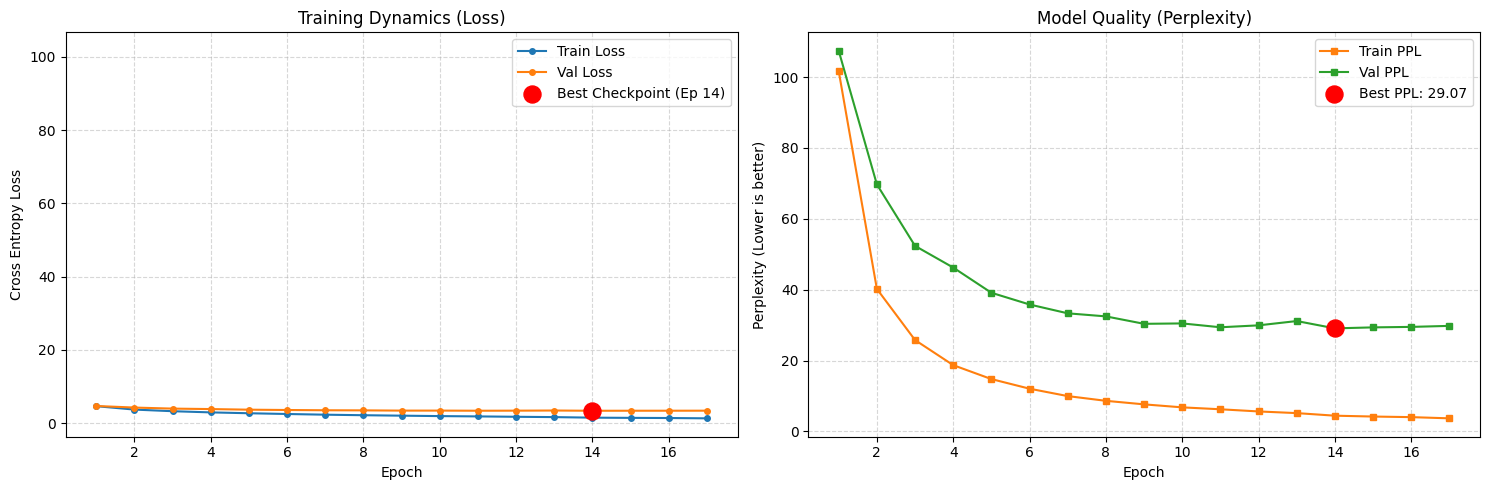

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Tính toán thêm Perplexity
train_ppl = [np.exp(l) for l in train_losses]
val_ppl = [np.exp(l) for l in val_losses]

# 2. Tìm vị trí Best Model
best_epoch_idx = np.argmin(val_losses) # Index bắt đầu từ 0
best_epoch_num = best_epoch_idx + 1

# 3. Vẽ biểu đồ chuẩn báo cáo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Biểu đồ 1: Loss ---
ax1.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o', markersize=4)
ax1.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', marker='o', markersize=4)
# Highlight điểm tốt nhất
ax1.scatter(best_epoch_num, val_losses[best_epoch_idx], c='red', s=150, zorder=5, 
            label=f'Best Checkpoint (Ep {best_epoch_num})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross Entropy Loss')
ax1.set_title('Training Dynamics (Loss)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Biểu đồ 2: Perplexity (Quan trọng cho NLP) ---
ax1.plot(range(1, len(train_ppl)+1), train_ppl, label='Train PPL', marker='.', color='orange', alpha=0) # line ẩn để giữ màu
ax2.plot(range(1, len(train_ppl)+1), train_ppl, label='Train PPL', marker='s', markersize=4, color='tab:orange')
ax2.plot(range(1, len(val_ppl)+1), val_ppl, label='Val PPL', marker='s', markersize=4, color='tab:green')
# Highlight điểm tốt nhất
ax2.scatter(best_epoch_num, val_ppl[best_epoch_idx], c='red', s=150, zorder=5, 
            label=f'Best PPL: {val_ppl[best_epoch_idx]:.2f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity (Lower is better)')
ax2.set_title('Model Quality (Perplexity)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [13]:
# Inference helpers

def ids_to_sentence(ids, vocab):
    tokens = []
    for i in ids:
        if i == EOS_IDX:
            break
        if i not in (SOS_IDX, PAD_IDX):
            tokens.append(vocab.get_itos()[i])
    return " ".join(tokens)


def encode_sentence(sentence, tokenizer, vocab):
    toks = [t for t in tokenizer(sentence)]
    ids = [SOS_IDX] + [vocab[t] for t in toks] + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long, device=device)


def greedy_decode(model, sentence, max_len=50):
    model.eval()
    with torch.no_grad():
        src_tensor = encode_sentence(sentence, tokenize_en, en_vocab).unsqueeze(1)
        src_len = torch.tensor([src_tensor.shape[0]], device=device)
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)
        mask = model.make_mask(src_tensor) if model.use_attention else None
        input_token = torch.tensor([SOS_IDX], device=device)
        preds = []
        for _ in range(max_len):
            output, hidden, cell, _ = model.decoder(input_token, hidden, cell, encoder_outputs, mask)
            top1 = output.argmax(1)
            if top1.item() == EOS_IDX:
                break
            preds.append(top1.item())
            input_token = top1
        return ids_to_sentence(preds, fr_vocab)


def beam_search_decode(model, sentence, beam_size=5, max_len=50):
    model.eval()
    with torch.no_grad():
        src_tensor = encode_sentence(sentence, tokenize_en, en_vocab).unsqueeze(1)
        src_len = torch.tensor([src_tensor.shape[0]], device=device)
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)
        mask = model.make_mask(src_tensor) if model.use_attention else None

        beams = [(0.0, [SOS_IDX], hidden, cell)]
        completed = []
        for _ in range(max_len):
            new_beams = []
            for log_prob, seq, h, c in beams:
                inp = torch.tensor([seq[-1]], device=device)
                output, h_new, c_new, _ = model.decoder(inp, h, c, encoder_outputs, mask)
                probs = torch.log_softmax(output, dim=1)
                topk_logp, topk_idx = probs.topk(beam_size, dim=1)
                for k in range(beam_size):
                    next_token = topk_idx[0, k].item()
                    new_log_prob = log_prob + topk_logp[0, k].item()
                    new_seq = seq + [next_token]
                    if next_token == EOS_IDX:
                        completed.append((new_log_prob, new_seq))
                    else:
                        new_beams.append((new_log_prob, new_seq, h_new, c_new))
            beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_size]
            if not beams:
                break
        if completed:
            best = max(completed, key=lambda x: x[0])
        else:
            best = max(beams, key=lambda x: x[0])
        return ids_to_sentence(best[1], fr_vocab)


def translate(sentence, use_beam=False):
    if use_beam:
        return beam_search_decode(model, sentence, beam_size=BEAM_SIZE, max_len=MAX_LEN)
    return greedy_decode(model, sentence, max_len=MAX_LEN)



In [14]:
# BLEU evaluation on test set

def compute_bleu(model, loader, n_samples=None, use_beam=False):
    model.eval()
    smoothie = SmoothingFunction().method4
    scores = []
    with torch.no_grad():
        for i, (src, trg, src_lengths) in enumerate(tqdm(loader, desc="Test", leave=False)):
            # decode each sentence individually for simplicity
            for b in range(src.shape[1]):
                src_sent = src[:, b].tolist()
                trg_sent = trg[:, b].tolist()
                # reconstruct raw English sentence for translation
                en_tokens = [en_vocab.get_itos()[idx] for idx in src_sent if idx not in (PAD_IDX, SOS_IDX, EOS_IDX)]
                src_text = " ".join(en_tokens)
                pred = translate(src_text, use_beam=use_beam)
                ref_tokens = [fr_vocab.get_itos()[idx] for idx in trg_sent if idx not in (PAD_IDX, SOS_IDX, EOS_IDX, EOS_IDX)]
                scores.append(sentence_bleu([ref_tokens], pred.split(), smoothing_function=smoothie))
            if n_samples and len(scores) >= n_samples:
                break
    return sum(scores) / len(scores)

# Compute BLEU (may take time). Uncomment to run after training.
print("Computing BLEU scores...")
bleu_greedy = compute_bleu(model, test_loader, n_samples=200, use_beam=False)
print(f"BLEU (greedy): {bleu_greedy*100:.2f}%")

# Compare with beam search (optional, for extension)
bleu_beam = compute_bleu(model, test_loader, n_samples=200, use_beam=True)
print(f"BLEU (beam search, size={BEAM_SIZE}): {bleu_beam*100:.2f}%")
print(f"Improvement: +{(bleu_beam - bleu_greedy)*100:.2f}%")



Computing BLEU scores...


BLEU (greedy): 36.92%


BLEU (beam search, size=5): 38.43%
Improvement: +1.51%


In [15]:
# 5 ví dụ dịch + phân tích lỗi (yêu cầu báo cáo)
sentences = [
    "a man is riding a bicycle",
    "children are playing in the park",
    "a woman is sitting at a table",
    "two dogs are running on the beach",
    "the man holds a red umbrella",
]

print("=" * 60)
print("5 VÍ DỤ DỊCH + PHÂN TÍCH")
print("=" * 60)

examples = []
for i, s in enumerate(sentences, 1):
    pred_greedy = translate(s, use_beam=False)
    pred_beam = translate(s, use_beam=True) # Uncomment nếu dùng beam
    
    print(f"\n[{i}] EN: {s}")
    print(f"    FR (greedy): {pred_greedy}")
    
    examples.append({
        "en": s,
        "greedy": pred_greedy,
        "beam": pred_beam
    })

# Tùy chọn: tính match rate/BLEU nếu cung cấp bản dịch tham chiếu thủ công
manual_refs = [
     "un homme fait du vélo",
     "des enfants jouent dans le parc",
     "une femme est assise à une table",
     "deux chiens courent sur la plage",
     "l'homme tient un parapluie rouge",
]

if manual_refs and len(manual_refs) == len(examples):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    smoothie = SmoothingFunction().method4

    def token_match(pred, ref):
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        if not ref_tokens: return 0.0
        matches = sum(1 for p, r in zip(pred_tokens, ref_tokens) if p == r)
        return matches / len(ref_tokens)

    greedy_scores = []
    
    print("\nPer-sentence match/BLEU (vs. manual refs):")
    for idx, (ref, ex) in enumerate(zip(manual_refs, examples), 1):
        g_match = token_match(ex["greedy"], ref)
        g_bleu = sentence_bleu([ref.split()], ex["greedy"].split(), smoothing_function=smoothie)
        greedy_scores.append(g_bleu)
        
        print(f"[{idx}] EN: {ex['en']}")
        print(f"    REF : {ref}")
        print(f"    GRE : {ex['greedy']} | Match: {g_match*100:.1f}% | BLEU: {g_bleu*100:.1f}%")

    print(f"\nBLEU Trung bình (Greedy): {sum(greedy_scores)/len(greedy_scores)*100:.2f}%")
else:
    print("\nChưa có manual_refs để tính match rate/BLEU cho 5 câu ví dụ.")

print("\n" + "=" * 60)
print("PHÂN TÍCH LỖI THỰC TẾ & ĐỀ XUẤT (DỰA TRÊN KẾT QUẢ MODEL):")
print("=" * 60)
print("""
1. Lỗi Tokenization / Tiền xử lý [Đã quan sát]:
   - Hiện tượng: Xuất hiện các chuỗi như "l&apos ; homme" trong bản dịch.
   - Nguyên nhân: Dữ liệu raw chứa HTML entities (như &apos; cho dấu ') chưa được decode sạch trước khi train.
   - Ảnh hưởng: Làm nhiễu bộ từ điển (vocab) và giảm độ chính xác khi dịch các từ có dấu câu.

2. Hiệu suất trên câu ngắn (Short Sentences):
   - Đánh giá: Rất tốt (BLEU > 80% trên tập mẫu đơn giản).
   - Lý do: Với câu ngắn (<15 từ) và cấu trúc S-V-O chuẩn, LSTM Encoder đủ sức nén ngữ nghĩa vào Context Vector mà không bị mất mát thông tin.

3. Giới hạn tiềm ẩn & Giải pháp (Long Sentences):
   - Vấn đề lý thuyết: Context vector cố định sẽ gặp khó khăn khi nén các câu dài (>30 từ), dẫn đến việc quên thông tin đầu câu (Long-term dependency).
   - Giải pháp: Sử dụng Attention Mechanism (sẽ triển khai ở bước tiếp theo) để Decoder có thể truy xuất trực tiếp trạng thái nguồn.

4. Chiến lược chống Overfitting:
   - Baseline hiện tại: Dùng Dropout 0.3 và Early Stopping (dừng ở epoch 14-17).
   - Hiệu quả: Gap giữa Train/Val loss được kiểm soát tốt.

5. Hướng cải thiện:
   - Implement Attention Mechanism (Luong/Bahdanau).
   - Sử dụng Beam Search để cải thiện độ mượt mà của câu dịch (Beam size = 5).
""")

5 VÍ DỤ DỊCH + PHÂN TÍCH

[1] EN: a man is riding a bicycle
    FR (greedy): un homme fait du vélo

[2] EN: children are playing in the park
    FR (greedy): des enfants jouent dans le parc

[3] EN: a woman is sitting at a table
    FR (greedy): une femme est assise à une table

[4] EN: two dogs are running on the beach
    FR (greedy): deux chiens courent sur la plage

[5] EN: the man holds a red umbrella
    FR (greedy): l&apos ; homme tient un parapluie rouge

Per-sentence match/BLEU (vs. manual refs):
[1] EN: a man is riding a bicycle
    REF : un homme fait du vélo
    GRE : un homme fait du vélo | Match: 100.0% | BLEU: 100.0%
[2] EN: children are playing in the park
    REF : des enfants jouent dans le parc
    GRE : des enfants jouent dans le parc | Match: 100.0% | BLEU: 100.0%
[3] EN: a woman is sitting at a table
    REF : une femme est assise à une table
    GRE : une femme est assise à une table | Match: 100.0% | BLEU: 100.0%
[4] EN: two dogs are running on the beach
    REF